In [1]:
#import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from intake import open_catalog
import cartopy.io.shapereader as shpreader
#import mygrads as mg
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
import math
from sklearn.neighbors import NearestNeighbors

In [1]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/6hrly_mslp_global.nc'
DS_slp=xr.open_dataset(f)
DS_slp

NameError: name 'xr' is not defined

In [8]:
slp_global_6hr=DS_slp['SLP']
slp_global_6hr

<xarray.DataArray 'SLP' (time: 62824, lat: 361, lon: 576)>
[13063371264 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0

In [15]:
winter_slp_only=slp_global_6hr.isel(time=slp_global_6hr.time.dt.season.isin(['DJF']))
winter_slp_only

<xarray.DataArray 'SLP' (time: 15524, lat: 361, lon: 576)>
array([[[ 99693.65 ,  99693.65 , ...,  99693.65 ,  99693.65 ],
        [ 99715.914,  99716.25 , ...,  99715.4  ,  99715.69 ],
        ...,
        [103070.71 , 103070.21 , ..., 103070.71 , 103070.71 ],
        [102914.54 , 102914.54 , ..., 102914.54 , 102914.54 ]],

       [[ 99701.945,  99701.945, ...,  99701.945,  99701.945],
        [ 99709.72 ,  99709.87 , ...,  99709.445,  99709.59 ],
        ...,
        [103230.62 , 103230.445, ..., 103231.28 , 103231.12 ],
        [103080.62 , 103080.62 , ..., 103080.62 , 103080.62 ]],

       ...,

       [[ 97894.52 ,  97894.52 , ...,  97894.52 ,  97894.52 ],
        [ 97996.02 ,  97995.52 , ...,  97997.02 ,  97996.52 ],
        ...,
        [102047.52 , 102048.02 , ..., 102046.44 , 102047.02 ],
        [101913.85 , 101913.85 , ..., 101913.85 , 101913.85 ]],

       [[ 97878.945,  97878.945, ...,  97878.945,  97878.945],
        [ 97910.78 ,  97910.28 , ...,  97911.28 ,  97910.945],
 

In [16]:
import xesmf as xe

In [17]:
new_lat=np.arange(-90,90,0.5)
new_lon=np.arange(-180,180,0.5)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)
                    })

In [19]:
regridder=xe.Regridder(winter_slp_only,ds_out,'bilinear',reuse_weights=True) 
regridder

Reuse existing file: bilinear_361x576_360x720.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x576_360x720.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 576) 
Output grid shape:          (360, 720) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [20]:
print(winter_slp_only.nbytes/1e9,"GB")

12.911993856 GB


In [13]:
import dask.array as da


In [21]:
dr_out=regridder(winter_slp_only).to_dataset(name='SLP')
dr_out

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 15524)
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00
Data variables:
    SLP      (time, lat, lon) float64 9.969e+04 9.969e+04 ... 1.024e+05 0.0

In [22]:
dr_out.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/slp_6hrly_regrid_allyears.nc')

### Load in Re-gridded file and apply spherical harmonics (to total field first)

In [2]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/slp_6hrly_regrid_allyears.nc'
DS_slp_regrid=xr.open_dataset(f)
DS_slp_regrid

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 15524)
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00
Data variables:
    SLP      (time, lat, lon) float64 ...

In [3]:
times=DS_slp_regrid['time']
times

<xarray.DataArray 'time' (time: 15524)>
array(['1980-01-01T00:00:00.000000000', '1980-01-01T06:00:00.000000000',
       '1980-01-01T12:00:00.000000000', ..., '2022-12-31T06:00:00.000000000',
       '2022-12-31T12:00:00.000000000', '2022-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00

In [4]:
slp_regrid_array=DS_slp_regrid['SLP']
slp_regrid_array

<xarray.DataArray 'SLP' (time: 15524, lat: 360, lon: 720)>
[4023820800 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00
Attributes:
    regrid_method:  bilinear

In [5]:
lons=DS_slp_regrid['lon']
lats=DS_slp_regrid['lat']
#print(lats)

In [7]:
import pyshtools as pysh #ncar package to transform grid to spherical harmonics

In [9]:
#total field filtered SLP
new_grid=[]
for i in range(len(slp_regrid_array)):
    #print(i)
    clm=pysh.SHGrid.from_xarray(slp_regrid_array[i,:,:],'DH')
    clm_new=clm.expand(normalization='4pi')
    grid=pysh.expand.MakeGridDH(clm_new.coeffs)
    coeffs=pysh.expand.SHExpandDH(grid)
    coeffs_filtered2 = coeffs.copy() #bandpass filters the data based on spherical harmonic coefficients
    lmin, lmax = 5,71
    coeffs_filtered2[:, :lmin, :] = 0.
    coeffs_filtered2[:, lmax:, :] = 0.
    grid_filtered2 = pysh.expand.MakeGridDH(coeffs_filtered2, sampling=2)
    #print(grid_filtered2)
    new_grid.append(grid_filtered2)
filtered_xarray=xr.DataArray(new_grid,coords={'lon':lons,'lat':lats,'time':times},dims=('time','lat','lon'))
filtered_xarray.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/filtered_slp6hrly_global_totalfield_allyears.nc')

### Filter with SLP Anomalies

In [6]:
#Anomalies 
slp_regrid_anoms=slp_regrid_array.groupby('time.hour')-(slp_regrid_array.groupby('time.hour').mean(dim='time'))
slp_regrid_anoms

<xarray.DataArray 'SLP' (time: 15524, lat: 360, lon: 720)>
array([[[  122.6345457 ,   122.6345457 ,   122.6345457 , ...,
           122.6345457 ,   122.6345457 ,   122.6345457 ],
        [  194.56843436,   194.8772176 ,   195.14251466, ...,
           193.7867929 ,   194.0698293 ,     0.        ],
        [  246.81873631,   247.40732428,   247.99377598, ...,
           245.03535924,   245.64119082,     0.        ],
        ...,
        [ 1873.10141958,  1872.35193393,  1871.80425847, ...,
          1875.59361624,  1874.74520027,     0.        ],
        [ 1761.40103429,  1761.2053422 ,  1760.62204534, ...,
          1762.82017452,  1762.34262398,     0.        ],
        [ 1642.15098799,  1641.71568448,  1641.47963714, ...,
          1642.27485841,  1642.23028886,     0.        ]],

       [[  107.5122995 ,   107.5122995 ,   107.5122995 , ...,
           107.5122995 ,   107.5122995 ,   107.5122995 ],
        [  164.06914093,   164.26822743,   164.45843368, ...,
           163.46024464,   163.67057863,     0.        ],
        [  211.49628801,   211.64778421,   211.73111794, ...,
           211.16123344,   211.27903568,     0.        ],
...
        [  742.56518133,   743.80287451,   744.90093679, ...,
           738.83521133,   740.11556514,     0.        ],
        [  674.73844934,   675.47640272,   676.2165413 , ...,
           672.17325197,   672.961495  ,     0.        ],
        [  595.46249758,   595.82377413,   596.18528942, ...,
           594.32131015,   594.70655662,     0.        ]],

       [[-1706.83052048, -1706.83052048, -1706.83052048, ...,
         -1706.83052048, -1706.83052048, -1706.83052048],
        [-1622.97174536, -1623.27981427, -1623.49640143, ...,
         -1622.5849486 , -1622.8083142 ,     0.        ],
        [-1492.63950577, -1493.33852103, -1494.05486985, ...,
         -1490.64214648, -1491.29090415,     0.        ],
        ...,
        [ 1090.48881973,  1091.34079248,  1091.90695754, ...,
          1089.04843991,  1089.61218364,     0.        ],
        [ 1047.86897505,  1048.21863718,  1048.76879331, ...,
          1046.5465247 ,  1046.91010059,     0.        ],
        [  989.36441357,   989.73160175,   989.85511477, ...,
           988.76832504,   988.92808661,     0.        ]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00
    hour     (time) int64 0 6 12 18 0 6 12 18 0 6 ... 12 18 0 6 12 18 0 6 12 18

In [9]:
import pyshtools as pysh

In [10]:
#total field filtered SLP
new_grid_anoms=[]
for i in range(len(slp_regrid_anoms)):
    clm=pysh.SHGrid.from_xarray(slp_regrid_anoms[i,:,:],'DH')
    clm_new=clm.expand(normalization='4pi')
    grid=pysh.expand.MakeGridDH(clm_new.coeffs)
    coeffs=pysh.expand.SHExpandDH(grid)
    coeffs_filtered2 = coeffs.copy() #bandpass filters the data based on spherical harmonic coefficients
    lmin, lmax = 5,71
    coeffs_filtered2[:, :lmin, :] = 0.
    coeffs_filtered2[:, lmax:, :] = 0.
    grid_filtered2 = pysh.expand.MakeGridDH(coeffs_filtered2, sampling=2)
    #print(grid_filtered2)
    new_grid_anoms.append(grid_filtered2)
filtered_xarray_anoms=xr.DataArray(new_grid_anoms,coords={'lon':lons,'lat':lats,'time':times},dims=('time','lat','lon'))
filtered_xarray_anoms.to_netcdf('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/slp6hr_spatialbandpass_allyears_anoms.nc')

### LOAD IN FILTERED ANOMALIES

In [2]:
f='/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/slp6hr_spatialbandpass_allyears_anoms.nc'
DS_anoms_filt=xr.open_dataset(f)
DS_anoms_filt

<xarray.Dataset>
Dimensions:                        (lat: 360, lon: 720, time: 15524)
Coordinates:
  * lon                            (lon) float64 -180.0 -179.5 ... 179.0 179.5
  * lat                            (lat) float64 -90.0 -89.5 -89.0 ... 89.0 89.5
  * time                           (time) datetime64[ns] 1980-01-01 ... 2022-...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 ...

In [12]:
slp_filt=DS_anoms_filt['__xarray_dataarray_variable__']
slp_filt

<xarray.DataArray '__xarray_dataarray_variable__' (time: 15524, lat: 360, lon: 720)>
array([[[-237.64428 , -237.64428 , ..., -237.64428 , -237.64428 ],
        [-161.416049, -161.798221, ..., -160.670028, -161.039976],
        ...,
        [ 314.578108,  314.432054, ...,  314.830783,  314.711027],
        [ 219.045901,  218.986206, ...,  219.144058,  219.09852 ]],

       [[-229.444887, -229.444887, ..., -229.444887, -229.444887],
        [-148.38169 , -148.540285, ..., -148.082851, -148.229207],
        ...,
        [ 368.701117,  368.474471, ...,  369.116157,  368.915026],
        [ 282.585349,  282.507184, ...,  282.721331,  282.656735]],

       ...,

       [[-414.266448, -414.266448, ..., -414.266448, -414.266448],
        [-298.927942, -299.11024 , ..., -298.590427, -298.754667],
        ...,
        [1381.838012, 1383.072035, ..., 1379.316927, 1380.586296],
        [1278.525682, 1279.194619, ..., 1277.159762, 1277.847382]],

       [[-508.560989, -508.560989, ..., -508.560989, -508.560989],
        [-418.599333, -418.706516, ..., -418.408846, -418.500106],
        ...,
        [1707.490484, 1708.311889, ..., 1705.811664, 1706.657071],
        [1628.459327, 1628.927793, ..., 1627.501097, 1627.983753]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00

In [13]:
#in hPa
slp_filt_hpa=slp_filt/100
slp_filt_hpa

<xarray.DataArray '__xarray_dataarray_variable__' (time: 15524, lat: 360, lon: 720)>
array([[[-2.3764428 , -2.3764428 , -2.3764428 , ..., -2.3764428 ,
         -2.3764428 , -2.3764428 ],
        [-1.61416049, -1.61798221, -1.62186466, ..., -1.60306228,
         -1.60670028, -1.61039976],
        [-0.89285564, -0.89984886, -0.90696612, ..., -0.87262424,
         -0.87924294, -0.88598687],
        ...,
        [ 4.06440685,  4.06145583,  4.0583458 , ...,  4.07229794,
          4.06982873,  4.06719809],
        [ 3.14578108,  3.14432054,  3.14272893, ...,  3.14937346,
          3.14830783,  3.14711027],
        [ 2.19045901,  2.18986206,  2.18919441, ...,  2.1918251 ,
          2.19144058,  2.1909852 ]],

       [[-2.29444887, -2.29444887, -2.29444887, ..., -2.29444887,
         -2.29444887, -2.29444887],
        [-1.4838169 , -1.48540285, -1.48704979, ..., -1.47942633,
         -1.48082851, -1.48229207],
        [-0.79484533, -0.79825459, -0.80177482, ..., -0.78528655,
         -0.788361  , -0.79154736],
...
        [14.64538523, 14.66175371, 14.67789058, ..., 14.59488711,
         14.61195225, 14.62878485],
        [13.81838012, 13.83072035, 13.84288328, ..., 13.78029945,
         13.79316927, 13.80586296],
        [12.78525682, 12.79194619, 12.79854148, ..., 12.76462868,
         12.77159762, 12.77847382]],

       [[-5.08560989, -5.08560989, -5.08560989, ..., -5.08560989,
         -5.08560989, -5.08560989],
        [-4.18599333, -4.18706516, -4.18821638, ..., -4.1832557 ,
         -4.18408846, -4.18500106],
        [-3.40968222, -3.41226962, -3.41501198, ..., -3.40285357,
         -3.40497383, -3.40725017],
        ...,
        [17.64653012, 17.65681914, 17.66698281, ..., 17.61490635,
         17.62557422, 17.6361153 ],
        [17.07490484, 17.08311889, 17.09121274, ..., 17.04954272,
         17.05811664, 17.06657071],
        [16.28459327, 16.28927793, 16.29389123, ..., 16.27011385,
         16.27501097, 16.27983753]]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-12-31T18:00:00

Text(0.5, 1.0, 'MERRA2 Global SLP Filtered Anomalies (n=5-70)')

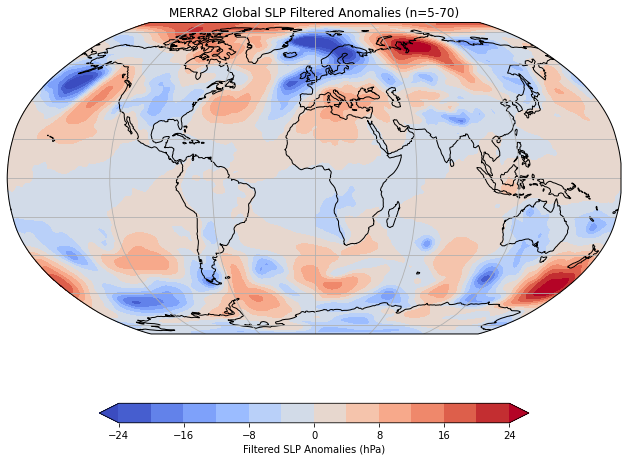

In [16]:
# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.Robinson())

# Add cyclic point to data
data=slp_filt_hpa[-1,:,:]
#data, lons = add_cyclic_point(data, coord=slp_filt['lon'])
max_val=24
increment=4
clevs = np.arange(start=-max_val, stop=max_val+increment, step=increment)
# Make a filled contour plot
cs=ax.contourf(slp_filt['lon'], slp_filt['lat'], data,clevs,
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Add colorbar
cbar = plt.colorbar(cs,shrink=0.7,orientation='horizontal',label='Filtered SLP Anomalies (hPa)')

# Add title
plt.title('MERRA2 Global SLP Filtered Anomalies (n=5-70)')


In [4]:
slp_filt.min(dim='time')

KeyboardInterrupt: 